In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import warnings

In [15]:
dataAssets = pd.read_csv('stock_assets.csv');

symbols = dataAssets['Symbol']

In [62]:
from datetime import datetime
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

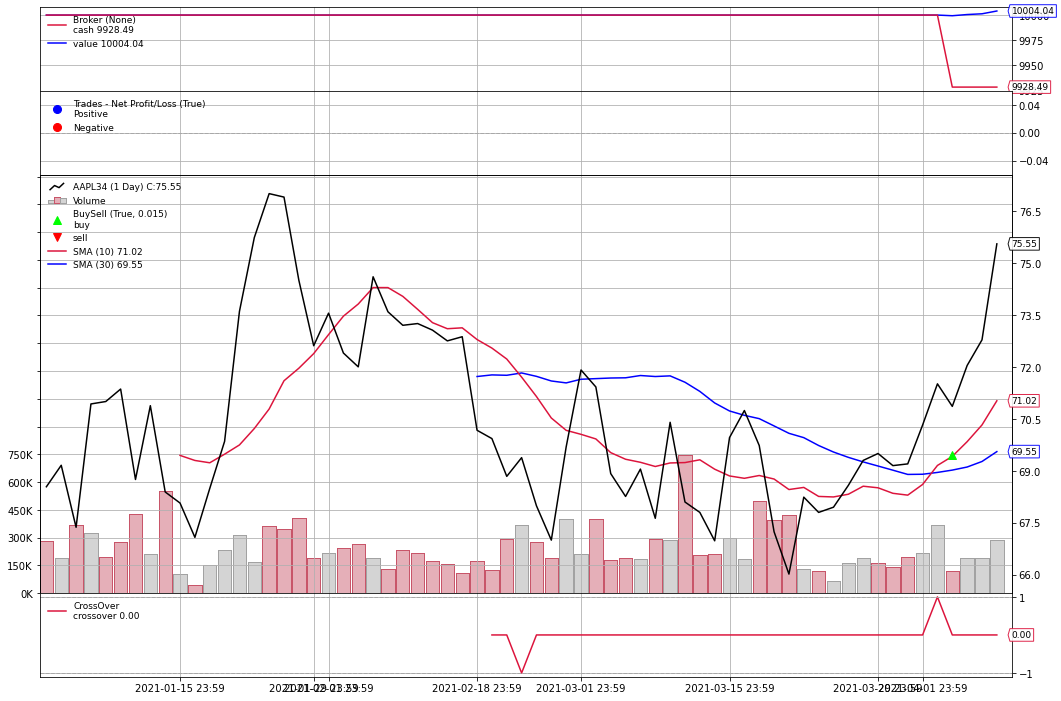

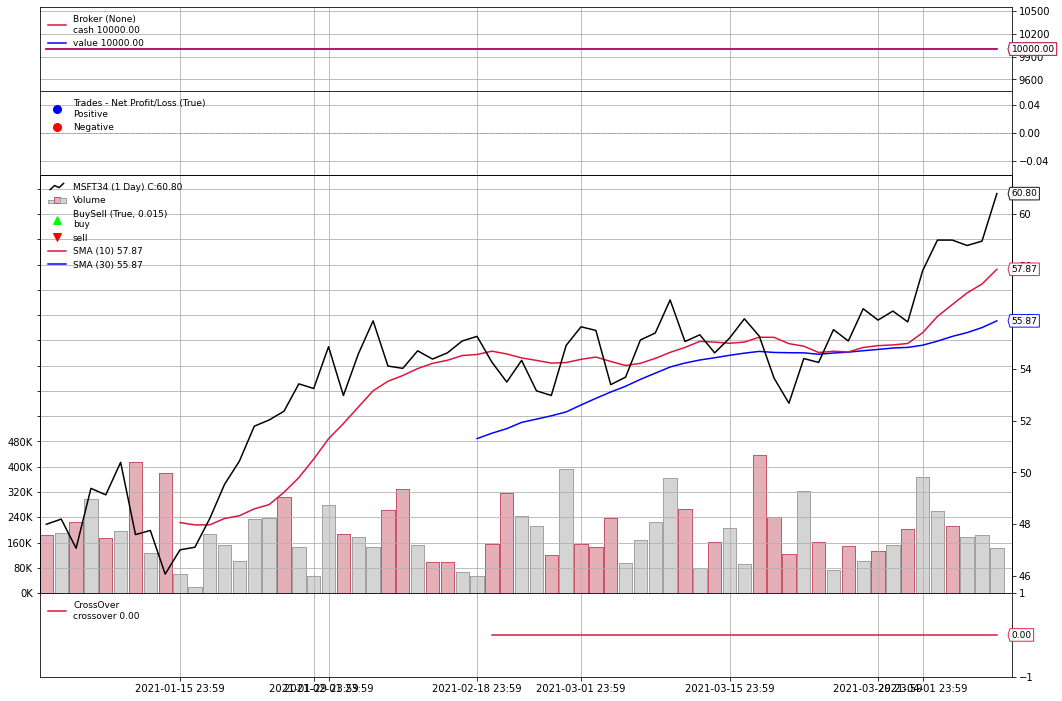

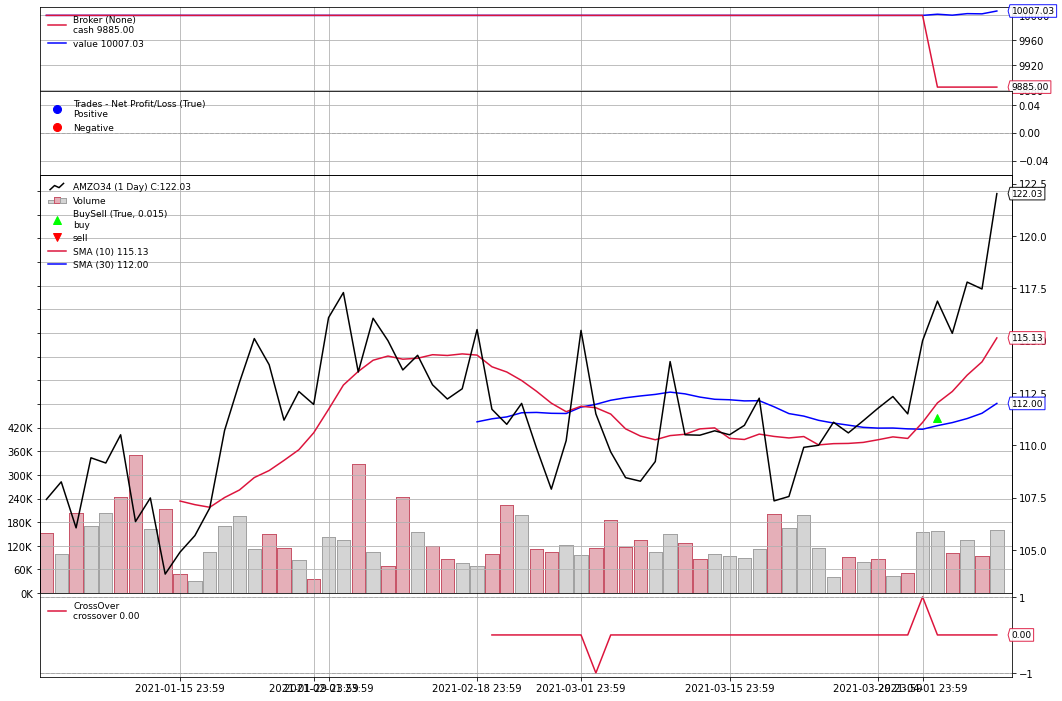

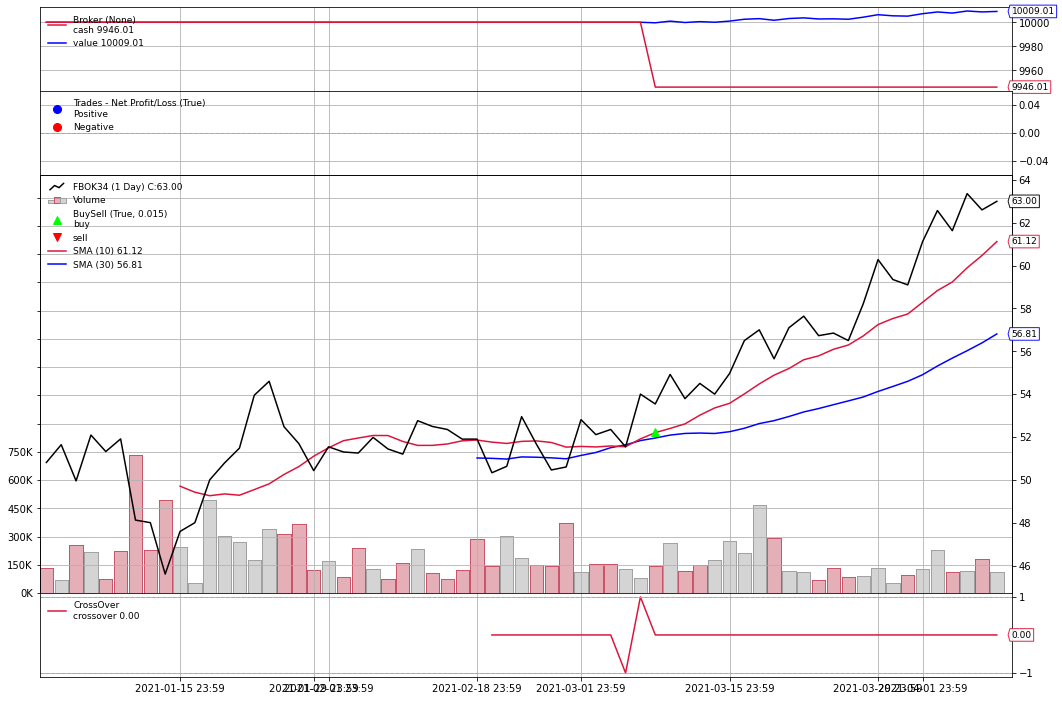

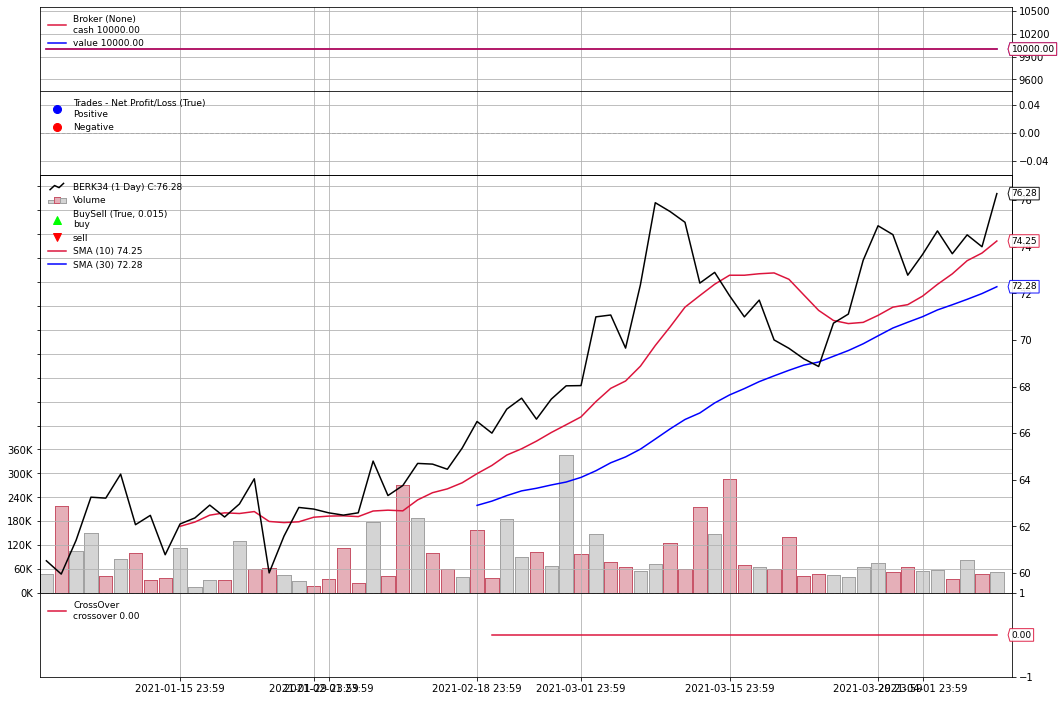

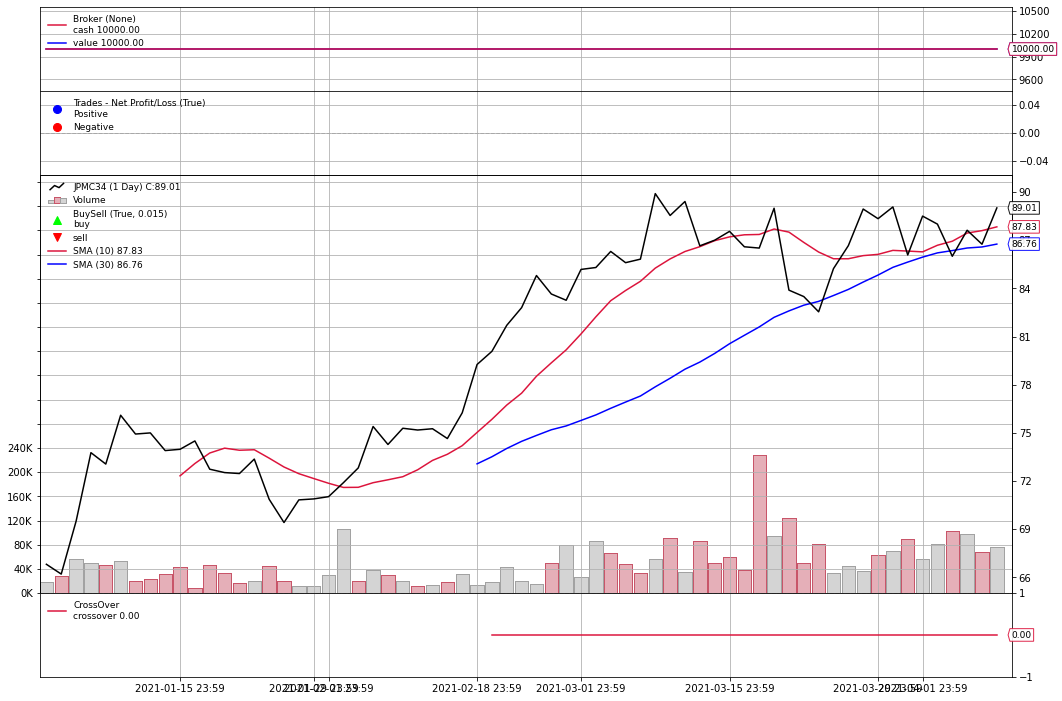

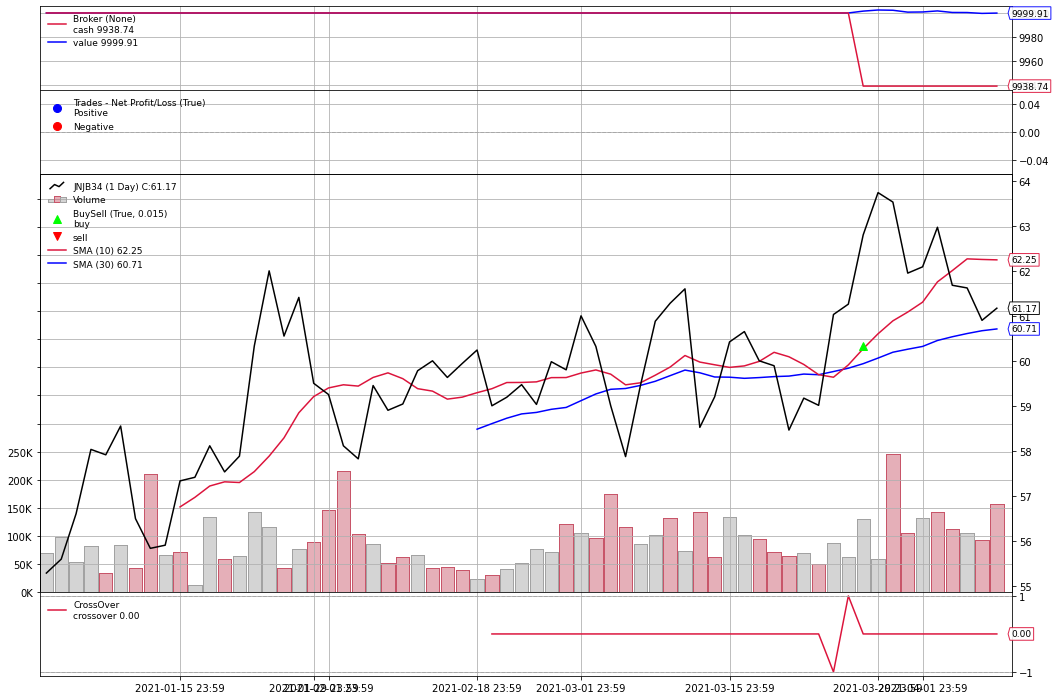

KeyboardInterrupt: 

In [63]:
%matplotlib inline

for symbol in symbols:
    
    cerebro = bt.Cerebro()
        
    try :
        
        data = bt.feeds.YahooFinanceData(dataname= symbol+'.SA',
                                     fromdate=datetime(2021, 1, 1),
                                     todate=datetime(2021, 4, 12))

        cerebro.adddata(data)

        cerebro.addstrategy(SmaCross)
        
        cerebro.run()
        
    except Exception:
        pass

            

    #plt.rcParams["figure.figsize"] = (15,10)

    #cerebro.plot(iplot=False);